# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [1]:
# !pip install git+https://github.com/huggingface/transformers.git@main

In [2]:
# !pip install -q datasets

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [3]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_captioning_blip_notebook", framework="pytorch")

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [4]:
from datasets import load_dataset
import json
from PIL import Image
import os

# dataset = load_dataset("ybelkada/football-dataset", split="train")

data = []
json_path='../../../dataset/hateful_memes/Muslims.jsonl'
img_path ='../../../dataset/hateful_memes/img'

image_paths, texts, labels = [], [], []

with open(json_path, 'r') as f:
    # Iterate over the lines in the file
    for line in f:
        # Load the JSON object from the line
        obj = json.loads(line)
        image_paths.append(os.path.join(img_path, obj['id'] + '.png'))

        texts.append(obj['text'])
        labels.append(obj['label'])

images=[Image.open(image_path) for image_path in image_paths]

for image, text, label in zip(images, texts, labels):
    item = {"image": image, "text": text, "label": label}
    data.append(item)

Let's retrieve the caption of the first example:

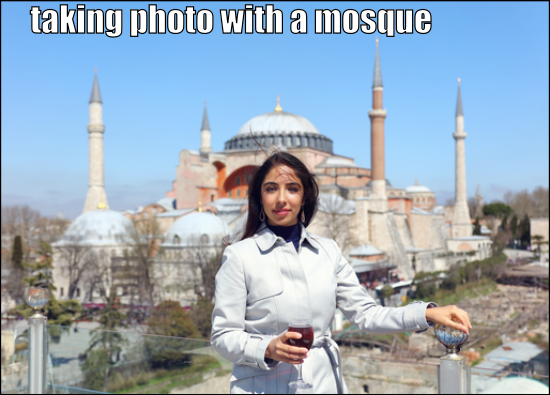

In [21]:
idx=0
data[idx]["text"]
data[idx]["image"]

And the corresponding image

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [6]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [7]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [8]:
from torch.utils.data import random_split

train_test_balance=0.5
train_val_balance=0.8

# Split data into train_data and test_data
train_data, test_data = random_split(data, [int(len(data)*train_test_balance), len(data)-int(len(data)*train_test_balance)])

# Create datasets
train_dataset = ImageCaptioningDataset(train_data, processor)
test_dataset = ImageCaptioningDataset(test_data, processor)

# Split train_dataset into train_dataset and val_dataset
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_data) * train_val_balance), len(train_data) - int(len(train_data) * train_val_balance)])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32)
test_dataloader = DataLoader(test_dataset,  shuffle=False, batch_size=32)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [9]:
import torch

# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# print(train_dataloader)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(10):
    # Training phase
    print("Epoch:", epoch)
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss

        print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for idx, batch in enumerate(val_dataloader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
            loss = outputs.loss
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print("Validation Loss:", val_loss)

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


: 

In [ ]:
# Test phase
model.eval()
test_loss = 0
with torch.no_grad():
    for idx, batch in enumerate(test_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss
        test_loss += loss.item()

test_loss /= len(test_dataloader)
print("Test Loss:", test_loss)

## Inference

Let's check the results on our train dataset

In [ ]:
# load image
example = data[0]
image = example["image"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

In [34]:
# from PIL import Image
# import requests
# from transformers import AutoProcessor, BlipModel
# import os
# import random
# import numpy as np

# seed = 0  # or any other number
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)


# model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")
# model.eval()
# processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# data_path='../dataset/hateful_memes/img'
# image = Image.open(os.path.join(data_path, '01276.png'))

# inputs = processor(text=["hateful", "non-hateful"], images=image, return_tensors="pt", padding=True)

# outputs = model(**inputs)

# logits_per_image = outputs.logits_per_image  # this is the image-text similarity score

# probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

# print(probs)

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

tensor([[0.6111, 0.3889]], grad_fn=<SoftmaxBackward0>)


In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipModel
import os
import random
import numpy as np

seed = 0  # or any other number
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

data_path='../dataset/hateful_memes/img'
image = Image.open(os.path.join(data_path, '01276.png'))

inputs = processor(text=["hateful", "non-hateful"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)

logits_per_image = outputs.logits_per_image  # this is the image-text similarity score

probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

print(probs)

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

tensor([[0.6111, 0.3889]], grad_fn=<SoftmaxBackward0>)


## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later. 
Meanwhile you can play with the model that we have fine-tuned!

In [13]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/488 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Let's check the results on our train dataset!

In [ ]:
'''from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")'''